# Gene based LSTM Model for Predicting Cellular Differentiation

This notebook predicts future gene expression changes by splitting the dataset by genes (rather than by cells/timepoints) and using gene level time-series windows

**Note:** In order to run the program, you must have all the following libraries imported into your database and replicate the setup. This process is detailed in the README.

The research paper goes into further depth about the code here and compares the two tasks- please refer for further reading.

The code is mostly written as functions in the shared_utils file for modularity, but explained in depth here.

In [5]:
from shared_utils import *

This command imports all neccacary functions from shared_utils.py in order for the program to run. The program is written this way to keep it modular and not too overwhelming in this notebook where the code is run.

## Loading Data

### Load Data from [GSE75748](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE75748)

The biological data are the temporal 758 single cells that differentiate from the mesoderm phase to the definitive endoderm.

In [4]:
print("Starting Gene-Based Forecasting...")

adata = load_data()

Starting Gene-Based Forecasting...
Loading data from GSE75748_sc_time_course_ec.csv...


The load_data() function uses pandas to read the large csv data file under the local variable df. Then once we have the csv file in df, the function converts it into a scanpy variable "adata" for biological preprocessing and visualization, and returns it into the public variable name "adata" which we can now use. 

In [6]:
adata = add_timepoint_data_to_adata(adata) 

Extracting timepoints from cell names to add to adata
Timepoint data added to adata.


Next, we want to add timepoints to the scanpy variable adata so that we can section the data by timepoint, a process that is very important for temporal data like cell differentiation. The temporal data can actually be extracted from the cell names since they start with H9.__h and the timepoint is there instead of the blank. So all we do to add the timepoint data into it's own column in adata is extract the timepoint from the names of the cells and add it into the column for each cell.

In [7]:
add_qc_metrics(adata)

QC metrics added to adata.obs:
['n_genes_by_counts', 'total_counts']


AnnData object with n_obs × n_vars = 758 × 19189
    obs: 'timepoint', 'sample_number', 'n_genes_by_counts', 'total_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

The function makes gene names unique and flags mitochondrial genes in adata.var. It then computes per-cell QC metrics (total_counts, n_genes_by_counts, pct_counts_mt) and returns the annotated AnnData without filtering or removing anything.

Plotting before filtering...


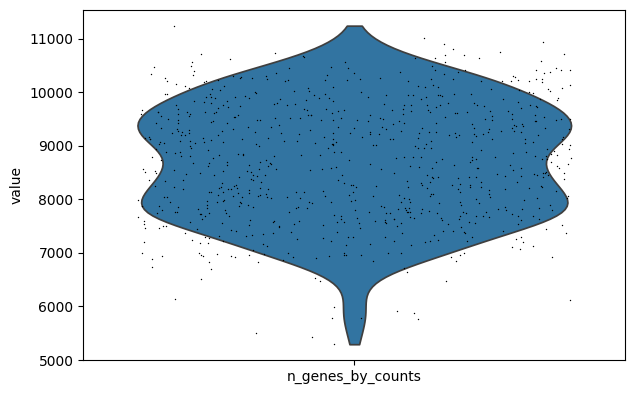

In [8]:
plot_before_filtering(adata)

We can see from the graph that our expression data is extremely varied before filitering. This graph highlights why it is important to do preprocessing, especially in the biological sense, because in order for the models to perform well, they must read off patterns. And patterns are easily recognized with more concise data rather than the random mess we have with real expression data.

## Data Preprocessing

In [9]:
adata_hvg = preprocess_data(adata)

Starting data preprocessing
Filtering cells and genes

Data shape after filtering: (758, 16863)

Normalizing and log transforming data


HVG filtering:
Highly variable genes found: 2000
After HVG filtering:

[0, 12, 24, 36, 72, 96]


Single-cell RNA sequencing data needs cleaning and processing before it can be used. Cells expressing fewer than 500 genes were removed, and genes expressed in fewer than 3 cells were also removed becausethey did not provide enough useful information. Normalization was applied so that very highly expressed genes did not dominate the results. A standard log-transformation was used. In the end, adata_hvg contains the 2000 most variable genes (from 19189) across all 758 cells. We select the most variable genes because they give us the most expression data to work.

In [12]:
gene_time_matrix, _ = create_gene_time_matrix(adata_hvg)

Creating gene-time matrix
  Expression data shape: (92, 2000)
  First three values in row: [1.06525890e-03 1.83659651e+00 6.07498533e-01]...

  Expression data shape: (102, 2000)
  First three values in row: [0.00105627 0.36513232 0.55956094]...

  Expression data shape: (66, 2000)
  First three values in row: [0.0053351  0.25281378 0.10561054]...

  Expression data shape: (172, 2000)
  First three values in row: [0.0036584  0.75394466 0.18623813]...

  Expression data shape: (138, 2000)
  First three values in row: [4.36164506e-04 1.05440790e+00 1.25326741e+00]...

  Expression data shape: (188, 2000)
  First three values in row: [0.01164793 0.91026402 1.5075981 ]...

Gene-time matrix fully created with shape: (2000, 6)


This function builds a gene-time matrix by averaging gene expression values across all cells belonging to each timepoint. For every timepoint, it selects the cells measured at that time, extracts their expression matrix, and computes the mean expression for each gene. The output show how many cells were present at each timepoint (for example, 92, 102, 66, etc.) and a few sample averaged values for the first three genes. These averaged values become a single column in the final matrix. After processing all timepoints, the resulting matrix has one row per gene and one column per timepoint. In the output, the matrix shape is (2000, 6), meaning 2,000 genes and 6 timepoints. This format provides a clean summary of expression trends over time, where each row represents how a gene’s average expression changes across the measured timepoints. Additionlly this matrix will make splitting the code especially easy.

## Splitting Data and Creating Windows

In [13]:
train_data, val_data, test_data = split_by_genes(gene_time_matrix)

Gene splitting: 2000 genes total
Train: 1400 genes, Val: 300 genes, Test: 300 genes


split_by_genes() takes the gene-time matrix, where each row is a single gene’s full expression trajectory across timepoints. It then splits these rows into training, validation, and test sets by gene. This means the model will see some genes during training, a different set of genes for validation, and a completely separate set of genes for testing. No gene appears in more than one split. This approach tests whether the model can generalize its learned temporal patterns to new genes it has never seen before, making evaluation stricter and preventing data leakage.

In [14]:
X_train, y_train = create_gene_windows(train_data, window_size=5, prediction_steps=1)
X_val, y_val = create_gene_windows(val_data, window_size=5, prediction_steps=1)
X_test, y_test = create_gene_windows(test_data, window_size=5, prediction_steps=1)

Gene windows created: 1400 samples. X shape: (1400, 5, 1), y shape: (1400, 1)
Gene windows created: 300 samples. X shape: (300, 5, 1), y shape: (300, 1)
Gene windows created: 300 samples. X shape: (300, 5, 1), y shape: (300, 1)


create_gene_windows() takes the split gene datasets (train, validation, or test), where each row contains a full gene expression time series, and converts them into sliding window samples that the model can learn from. For each gene, the function looks at the expression values across time and cuts them into overlapping windows of length 5 (the past 5 timepoints). Each window becomes an input sample X, and the very next timepoint becomes the target y the model is supposed to predict. If a gene has enough timepoints, this process generates multiple windows per gene. That is why your output shows many samples 1400 training windows, 300 validation windows, and 300 test windows, each with shape (5, 1) for X and shape (1,) for y. This prepares the data in a format that sequence models like LSTMs expect: a stack of short time sequences paired with the next value to predict.

In [16]:
input_shape = (X_train.shape[1], X_train.shape[2]) 
output_size = y_train.shape[1]

input_shape and output_size pull shape information from the training windows that shared_utils.py created (X_train and y_train). X_train is a table of many examples where each example is a short sequence of 5 timepoints and each timepoint has one number. output_size = 1 comes from y_train and tells the model there is one number to predict for each input window. These two values are used when building the LSTM (or any sequence model) so it knows the size and shape of the inputs and outputs.

## Building the LSTM and Feedforward Models

In [17]:
lstm_model = build_lstm_model(input_shape, output_size)

Building LSTM model: Input shape=(5, 1), Output size=1


/Users/paavan/dev/Cell_Diff/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM stands for Long Short-Term Memory, and it is a type of recurrent neural network designed to learn patterns that unfold over time. Unlike a feedforward network, an LSTM processes a sequence one time step at a time and keeps an internal memory that can carry useful information forward, which makes it effective for learning trends in gene expression. In this model, we stack two LSTM layers: the first outputs a full sequence so the second LSTM can analyze the transformed time series, and the final Dense layers convert the learned temporal features into a single predicted gene value. dropout randomly turns off some connections during training, and recurrent_dropout does the same inside the LSTM’s internal loops; both help reduce overfitting, which is especially important when working with small gene-time datasets. The model is trained with the Adam optimizer, which adapts learning rates automatically and often converges faster than standard SGD. If you see warnings about passing input_shape directly to LSTM layers, they do not break anything, though using an explicit Input() layer is a cleaner alternative. Overall, the LSTM is useful here because it can learn how a gene’s past expression levels influence its future values in a time-aware way, making it a strong choice for forecasting tasks.

In [18]:
ff_model = build_feedforward_model(input_shape, output_size)

Building feedforward model: Input shape=(5, 1), Output size=1


/Users/paavan/dev/Cell_Diff/.venv/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


The feedforward model takes each gene’s time window and flattens it into one long list of numbers. This removes the ordering of the time steps but keeps all the values, allowing a standard neural network to process the window as a simple vector. After flattening, the model passes the vector through one or more Dense (fully connected) layers, which compute weighted combinations of the inputs and apply activation functions to learn useful transformations. A final Dense layer outputs the predicted next gene value. Dropout layers are added between Dense layers to reduce overfitting by randomly deactivating neurons during training, which encourages the network to learn more stable patterns instead of memorizing the data. The model is trained using stochastic gradient descent (SGD) and mean squared error (MSE), which penalizes large errors and is standard for forecasting continuous values; mean absolute error (MAE) is included as an intuitive measure of average prediction error. Overall, the feedforward model is simple and usually trains faster, but because it ignores temporal order, it struggles to learn meaningful gene expression dynamics. As shown in the results, its performance is far weaker than the LSTM, but it still serves as an important control model that helps highlight the advantages of using a time aware model like the LSTM.

## Training the LSTM and Feedforward Models

In [19]:
print("\nTraining LSTM Model")
lstm_history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=250,
    verbose=1,
    callbacks=get_training_callbacks()
)
print(f"LSTM training completed after {len(lstm_history.history['loss'])} epochs.")


Training LSTM Model
Epoch 1/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.1506 - mae: 0.2076 - val_loss: 0.0688 - val_mae: 0.1559 - learning_rate: 0.0010
Epoch 2/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0974 - mae: 0.1738 - val_loss: 0.0756 - val_mae: 0.1433 - learning_rate: 0.0010
Epoch 3/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0778 - mae: 0.1591 - val_loss: 0.0792 - val_mae: 0.1408 - learning_rate: 0.0010
Epoch 4/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0871 - mae: 0.1526 - val_loss: 0.0465 - val_mae: 0.1341 - learning_rate: 0.0010
Epoch 5/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0659 - mae: 0.1406 - val_loss: 0.0391 - val_mae: 0.1221 - learning_rate: 0.0010
Epoch 6/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0833 - mae: 0.1472 - val_loss: 0.0487 - val_mae: 0.1342 - learning_rate: 0.0010
Epoch 7/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0803 - mae: 0.1435 - val_loss: 0.0362 - val_mae: 0.1268 - learnin

LSTMs typically take more time per epoch because they perform calculations across time steps, and they can also overfit more easily when the dataset is small because they have more parameters and more capacity to memorize the training data. The same training helpers (EarlyStopping and ReduceLROnPlateau) are especially important for recurrent models: EarlyStopping prevents the LSTM from training until it memorizes the training set, and the learning rate reducer helps fine tune the weights once the loss plateaus. When reviewing the training log, you should check the same things as for the feedforward model, whether training and validation losses are decreasing and whether they diverge, but you should also be patient with training time and consider smaller LSTM sizes or stronger dropout if the validation score is much worse than the training score.

In [ ]:
print("\nTraining Feedforward Model")
ff_history = ff_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=250,
    verbose=1,
    callbacks=get_training_callbacks()
)
print(f"Feedforward training completed after {len(ff_history.history['loss'])} epochs.")


--- Training Feedforward Model ---
Epoch 1/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3948 - mae: 0.2898 - val_loss: 0.1457 - val_mae: 0.1955 - learning_rate: 0.0100
Epoch 2/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1508 - mae: 0.1978 - val_loss: 0.1069 - val_mae: 0.1694 - learning_rate: 0.0100
Epoch 3/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1249 - mae: 0.1902 - val_loss: 0.0999 - val_mae: 0.1577 - learning_rate: 0.0100
Epoch 4/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1534 - mae: 0.1936 - val_loss: 0.0953 - val_mae: 0.1603 - learning_rate: 0.0100
Epoch 5/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1432 - mae: 0.1843 - val_loss: 0.0827 - val_mae: 0.1608 - learning_rate: 0.0100
Epoch 6/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0987 - mae: 0.1691 - val_loss: 0.0861 - val_mae: 0.1567 - learning_rate: 0.0100
Epoch 7/250
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1294 - mae: 0.1774 - val_loss: 0.0809 - val_mae: 0.1567 -

During training the model repeatedly looks at the training data in passes called epochs; after each epoch the notebook prints metrics such as the training loss (how far the model’s predictions are from the targets on the training set) and validation loss (the same measurement but on a held-out set not used for updating the model). The validation numbers give a better idea of how the model will perform on new, unseen data. EarlyStopping will stop training automatically if the validation loss does not improve for a certain number of epochs, preventing the model from overfitting to the training set, and ReduceLROnPlateau reduces the learning rate if validation loss stops improving so the optimizer can take smaller, more careful steps later in training. restore_best_weights=True ensures that after training finishes we keep the model weights from the epoch that had the best validation loss. When you look at the printed training curves, a healthy run shows both training and validation loss decreasing; if the validation loss starts rising while the training loss keeps decreasing, that is a sign of overfitting and the EarlyStopping callback will typically stop training before it gets worse.

## Evaluating the Models Performance

In [ ]:
print("\nFinal LSTM Model Evaluation")
lstm_rmse, lstm_mae, lstm_r2, y_pred_lstm = evaluate_performance(y_test, lstm_model.predict(X_test))


--- Final LSTM Model Evaluation ---
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
RMSE: 0.0955
MAE:  0.0591
R²:   0.8576


In [22]:
print("\n--- Final Feedforward Model Evaluation ---")
ff_rmse, ff_mae, ff_r2, y_pred_ff = evaluate_performance(y_test, ff_model.predict(X_test))


--- Final Feedforward Model Evaluation ---
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
RMSE: 0.1214
MAE:  0.0859
R²:   0.7700


After generating predictions, we evaluate the model using three common metrics. RMSE (root mean squared error) reports the average prediction error in the same units as the gene expression values while penalizing large mistakes more heavily. MAE (mean absolute error) is the average absolute difference between the predicted and true value and is useful because it is easy to interpret directly. R² measures how much of the variation in the gene’s future value the model can explain; values close to 1 indicate strong predictive power, values near 0 mean the model is no better than predicting the average, and negative values indicate worse-than-baseline performance. The visualization helpers make these numbers easier to understand: prediction-versus-actual plots show where the model tends to over- or under-predict, error histograms reveal how centered the errors are and whether there are many large deviations, and scatter plots with a diagonal reference line help you see how tightly the predictions follow the true values. The final performance comparison bar chart places the LSTM and feedforward metrics side by side so you can quickly see which approach performs better. Together, the metrics quantify accuracy, and the plots help diagnose whether the model’s errors are mostly random or reflect consistent patterns it failed to learn.

## Plotting Results LSTM vs Feedforward

**Note:** For plotting, please refer to the research paper for further information.


Plotting Training Histories


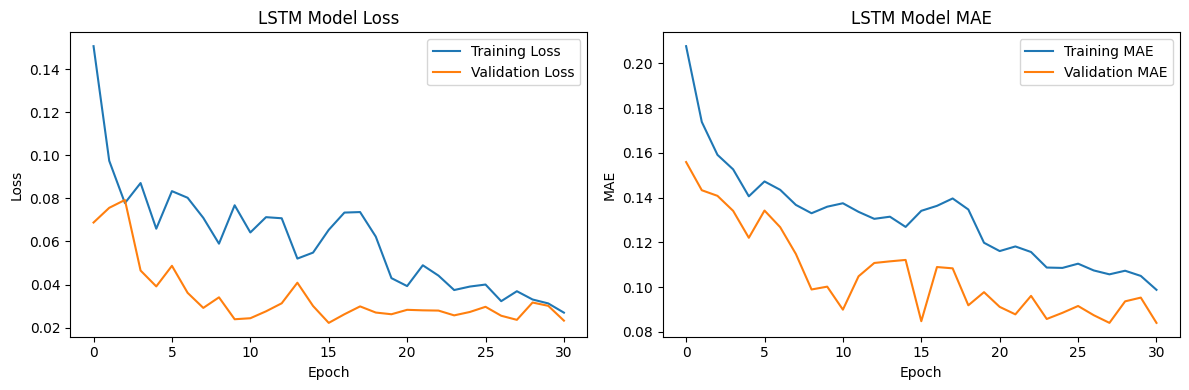

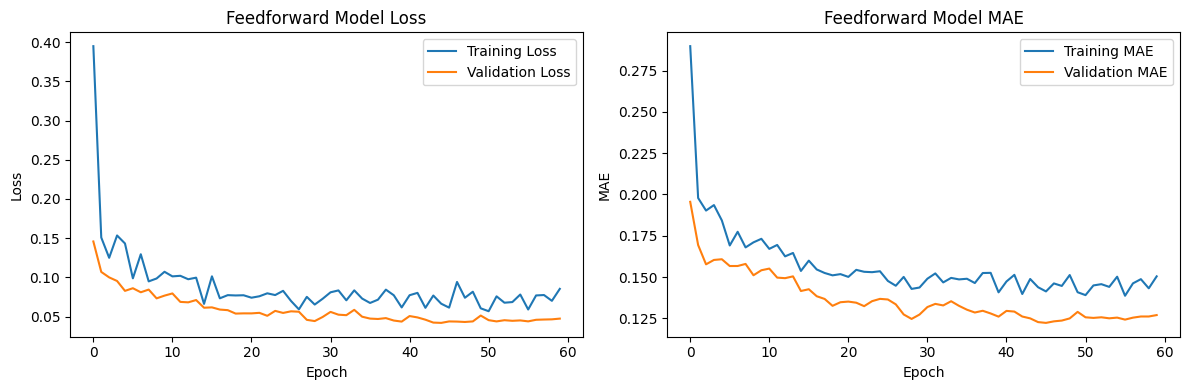


Plotting Prediction Comparisons


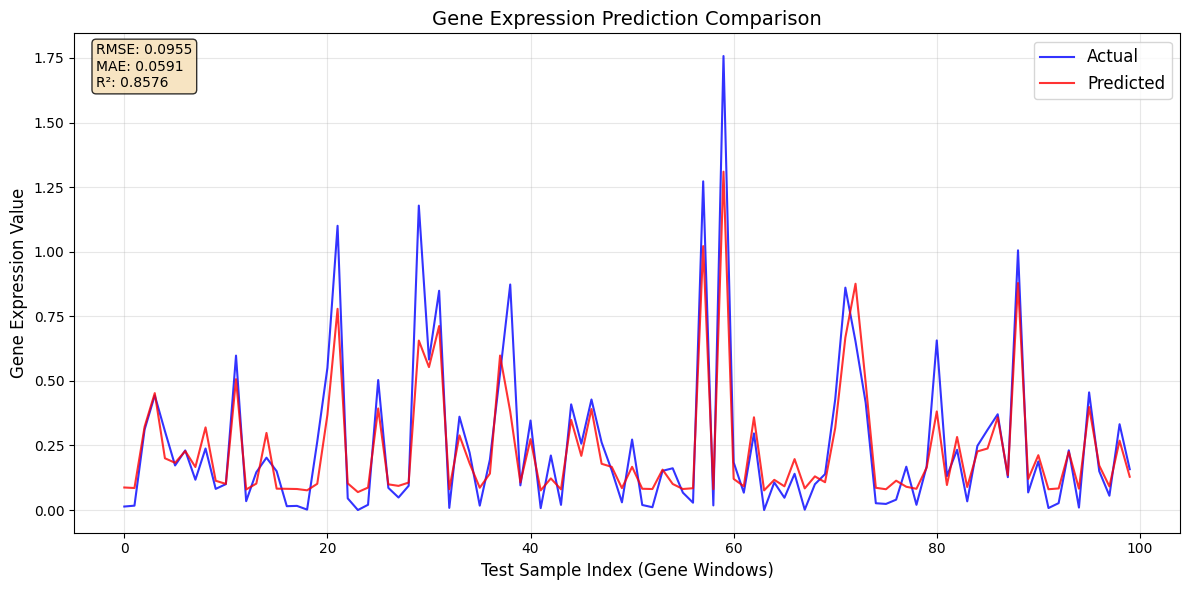

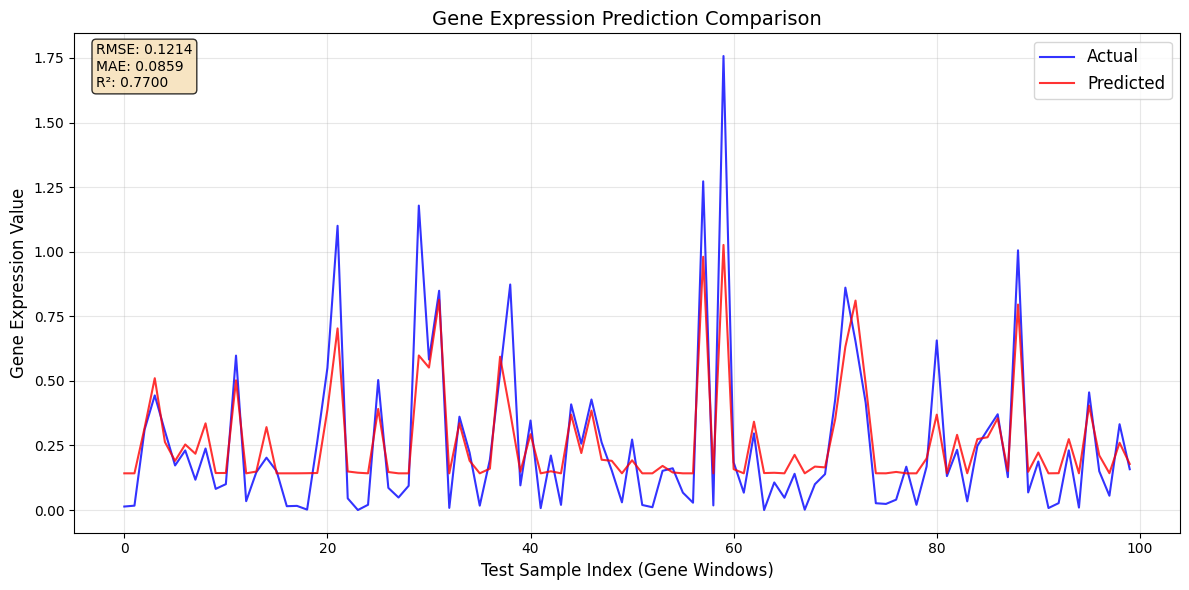

In [24]:
print("\nPlotting Training Histories")
plot_training_history(lstm_history, model_name="LSTM")
plot_training_history(ff_history, model_name="Feedforward")

print("\nPlotting Prediction Comparisons")
lstm_metrics = {'RMSE': lstm_rmse, 'MAE': lstm_mae, 'R²': lstm_r2}
plot_prediction_comparison(y_test, y_pred_lstm, model_type='gene', metrics_dict=lstm_metrics)

ff_metrics = {'RMSE': ff_rmse, 'MAE': ff_mae, 'R²': ff_r2}
plot_prediction_comparison(y_test, y_pred_ff, model_type='gene', metrics_dict=ff_metrics)


Plotting Diagnostic Plots


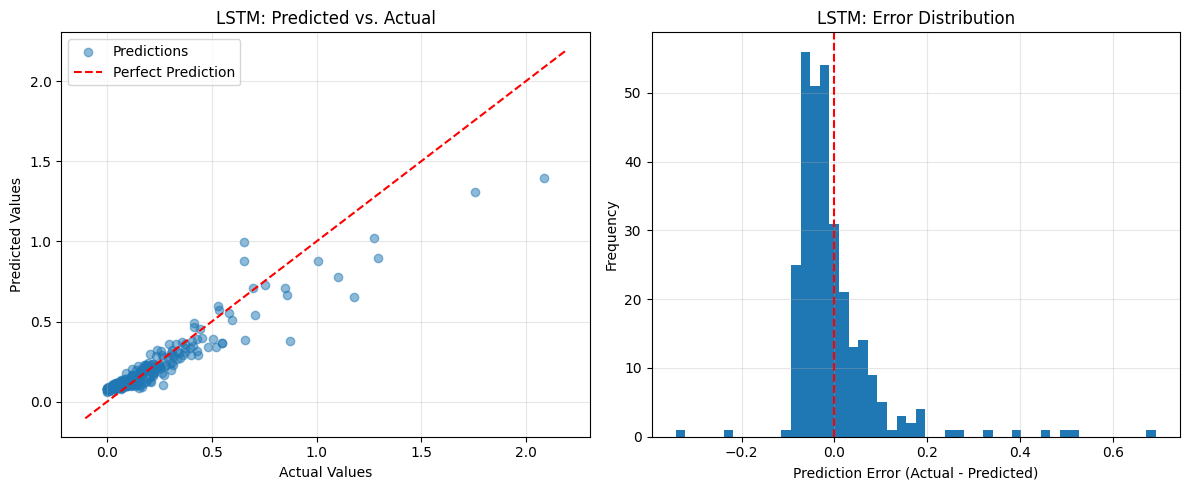

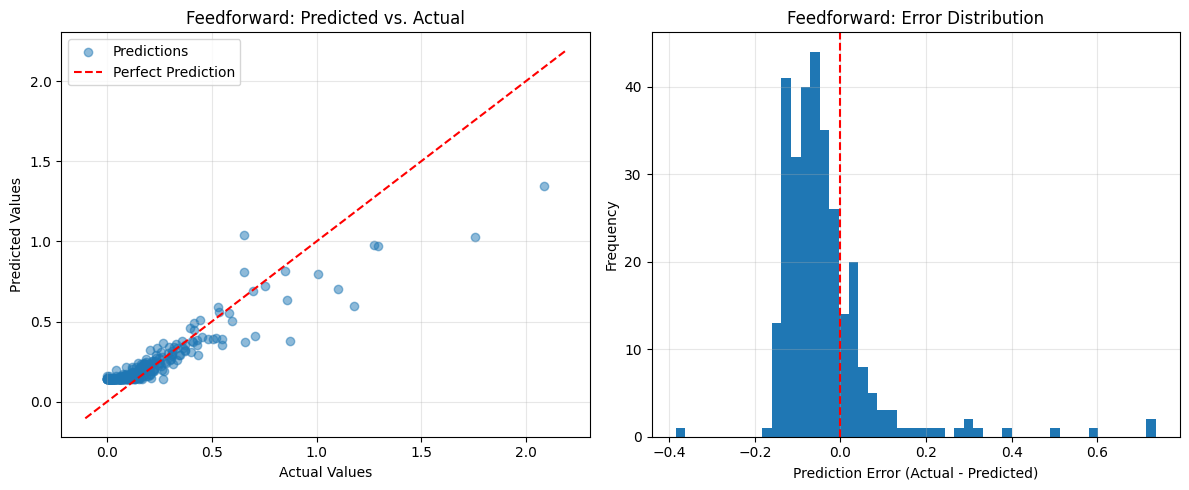

In [25]:
print("\nPlotting Diagnostic Plots")
plot_diagnostic_plots(y_test, y_pred_lstm, model_name="LSTM")
plot_diagnostic_plots(y_test, y_pred_ff, model_name="Feedforward")


--- Plotting Final Performance Comparison ---


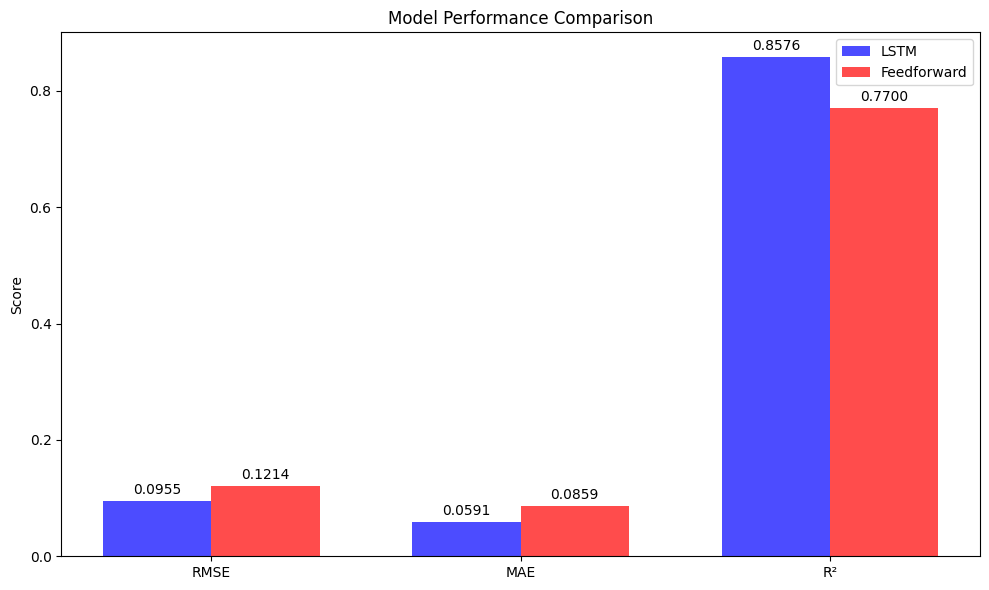

In [26]:
print("\n--- Plotting Final Performance Comparison ---")
lstm_metrics = {'RMSE': lstm_rmse, 'MAE': lstm_mae, 'R²': lstm_r2}
ff_metrics = {'RMSE': ff_rmse, 'MAE': ff_mae, 'R²': ff_r2}
plot_performance_comparison_bar_chart(lstm_metrics, ff_metrics)